In [11]:
!py -m pip install langgraph-checkpoint-sqlite

# !py -m pip install --upgrade --quiet  langchain langchain-community langchainhub langchain-openai langchain-chroma bs4

  Attempting uninstall: langgraph-checkpoint
    Found existing installation: langgraph-checkpoint 2.0.9
    Uninstalling langgraph-checkpoint-2.0.9:
      Successfully uninstalled langgraph-checkpoint-2.0.9



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
!py -m pip list

Package                                  Version
---------------------------------------- -------------------
absl-py                                  1.0.0
aiohttp                                  3.9.5
aiosignal                                1.3.1
altair                                   5.3.0
annotated-types                          0.6.0
anyio                                    3.5.0
argon2-cffi                              21.3.0
argon2-cffi-bindings                     21.2.0
asgiref                                  3.8.1
asttokens                                2.0.5
astunparse                               1.6.3
async-timeout                            4.0.3
asyncio                                  3.4.3
attrs                                    21.4.0
Babel                                    2.9.1
backcall                                 0.2.0
backoff                                  2.2.1
bcrypt                                   4.1.3
beautifulsoup4                           

opentelemetry-sdk                        1.24.0
opentelemetry-semantic-conventions       0.45b0
opentelemetry-util-http                  0.45b0
opt-einsum                               3.3.0
ordered-set                              4.1.0
orjson                                   3.10.1
overrides                                7.7.0
packaging                                23.2
pandas                                   2.2.3
pandocfilters                            1.5.0
parso                                    0.8.3
pathspec                                 0.9.0
patsy                                    0.5.6
pdf2image                                1.17.0
pickleshare                              0.7.5
pillow                                   10.4.0
pip                                      24.3.1
pipreqs                                  0.5.0
platformdirs                             4.3.6
playsound                                1.3.0
plotly                                   5.19.0
plotni

In [2]:
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
import pandas as pd
import os
import shutil
import numpy as np
from uuid import uuid4
from langchain_community.document_loaders import PyPDFLoader, UnstructuredWordDocumentLoader
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain.prompts import ChatPromptTemplate
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.docstore.document import Document
from typing import List, Tuple
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langgraph.store.base import BaseStore
from langchain_core.messages import SystemMessage, HumanMessage
import re
from typing import Annotated, TypedDict
import operator
from langchain_core.documents import Document
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage

In [3]:
OPENAI_DEPLOYMENT_ENDPOINT = "https://advancedanalyticsopenaikey.openai.azure.com/"
OPENAI_DEPLOYMENT_ENDPOINT_embed = "https://pkl-aa-dev-aiservices.openai.azure.com/" 
OPENAI_API_KEY = "FqFd4DBx1W97MSVjcZvdQsmQlhI80hXjl48iWYmZ4W3NutUlWvf0JQQJ99BDACYeBjFXJ3w3AAABACOGl3xo" 
OPENAI_API_VERSION = "2024-12-01-preview"
OPENAI_API_KEY_EMBEDDINGS = "AXEC3y1jC9ZNGCBB12NZwrpBSzScq1esexgvCXiqw7PaHE04vSMbJQQJ99BDACYeBjFXJ3w3AAABACOG4CMN" 
OPENAI_DEPLOYMENT_NAME = "gpt-4o"
OPENAI_MODEL_NAME="gpt-4o"
embedding_api_version = "2024-02-01"

# OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
# CHROMA_PATH = "c:\\Users\\SujaySunilNagvekar\\VM\\GEN AI\\SERFF\\vector_db\\testing_db"
DB_PATH  = "C:\\Users\\SujaySunilNagvekar\\VM\\GEN AI\\KM\\vector_db"
DATA_FOLDER = "C:\\Users\\SujaySunilNagvekar\\VM\\GEN AI\\KM\\Documents"

### Cohere API key 
# cohere_API_key = "wHyiTViP32Y3Q8Qwhjmd4QGNCkYNpxqtsemtSri3"
# co = cohere.Client(cohere_API_key)

In [4]:

llm = AzureChatOpenAI(
                        temperature=0,
                        deployment_name=OPENAI_DEPLOYMENT_NAME,
                        model_name=OPENAI_MODEL_NAME,
                        azure_endpoint=OPENAI_DEPLOYMENT_ENDPOINT,
                        openai_api_version=OPENAI_API_VERSION,
                        openai_api_key=OPENAI_API_KEY            
                    )

embeddings = AzureOpenAIEmbeddings(
                        deployment="text-embedding-3-small",
                        model="text-embedding-3-small",
                        azure_endpoint=OPENAI_DEPLOYMENT_ENDPOINT_embed,
                        openai_api_version=embedding_api_version,
                        openai_api_key=OPENAI_API_KEY_EMBEDDINGS)


# Graphstate

In [5]:
from typing import TypedDict, List, Optional
from langchain_core.messages import BaseMessage
from pydantic import BaseModel, Field
from langchain_core.documents import Document

class GraphState(TypedDict, total=False):
    user_query: str
    reformulated_query: str
    reformulation_required: bool
    subqueries: list  # includes SQL and RAG subqueries
    rag_outputs: Annotated[list[Document], operator.add]  # ✅ RAG chunks accumulated
    sql_outputs: Annotated[list[str], operator.add]       # ✅ SQL results accumulated
    final_response: str
    memory: list


### Query Analyser

In [6]:
from pydantic import BaseModel, Field
reformulation_prompt = """
Given the chat history and the latest user question, which might reference context in the chat history, 
reformulate the question into a standalone question that can be understood without the chat history. 
If the question is related to the most recent queries or requires context from the chat history to be understood, 
include that context in the reformulated question. Do NOT answer the question; just provide the reformulated version.
"""

reformulation_decision_prompt = """
You are an assistant that determines whether the user query requires reformulation using prior chat history.
Answer True only if the query is ambiguous, vague, or clearly follows from prior conversation.
Answer False if the query is already self-contained and understandable on its own.

Respond using the function format below.
"""

class ReformulatedQuery(BaseModel):
    """Rewritten query that includes necessary context."""
    reformulated_query: str = Field(
        description="A rewritten version of the user's question that includes necessary context from prior conversation."
    )

class ReformulationDecision(BaseModel):
    """Boolean flag for whether reformulation is required."""
    requires_reformulation: bool = Field(
        description="True if query depends on chat history or is ambiguous."
    )



# Prompt templates
clarity_prompt = ChatPromptTemplate.from_messages([
    ("system", reformulation_decision_prompt.strip()),
    ("human", "Chat History:\n{memory}\n\nCurrent User Question:\n{user_query}\n\nDoes this query require reformulation?")
])

contextualize_prompt = ChatPromptTemplate.from_messages([
    ("system", reformulation_prompt.strip()),
    ("human", "Chat History:\n{memory}\n\nCurrent User Question:\n{user_query}\n\nRewritten Question:")
])

# LLM Structured Output
structured_clarity_resolution = llm.with_structured_output(
    schema=ReformulationDecision,
    method="function_calling"
)

structured_llm_reformulation_resolution = llm.with_structured_output(
    schema=ReformulatedQuery,
    method="function_calling"
)

# Composable chains
chain_query_clarity_check = clarity_prompt | structured_clarity_resolution
chain_reformulation = contextualize_prompt | structured_llm_reformulation_resolution


In [7]:
from langchain_core.tools import tool
from functools import partial

def make_retrieve_recent_memory_tool(store: BaseStore, user_id: str):
    @tool
    def retrieve_recent_memory(user_query: str = "") -> str:
        """
        Retrieves the most relevant recent memories (up to 3) for the given user query.
        """
        print("📚 Retrieving recent memory for user_id:", user_id)
        namespace = (user_id, "memories")

        recent_memories = store.search(namespace, query=user_query, limit=3)
        print(f"🧠 Retrieved {len(recent_memories)} past memories")

        memory_str = "\n\n".join([
            f"User: {m.value.get('user_query', '')}\nRewritten: {m.value.get('reformulated_query', '')}\nAnswer: {m.value.get('final_response', '')}"
            for m in recent_memories
        ])
        return memory_str or "(no relevant memory found)"

    return retrieve_recent_memory



In [8]:
from langchain_core.tools import tool

@tool
def query_reformulator_tool(user_query: str, memory: str = "") -> str:
    """
    Reformulates the user query using memory/context if necessary.
    Returns a clarified or reformulated query for the agent to proceed with.
    """
    print("🧐 Checking query clarity and possibly reformulating...")

    # Step 1: Structured decision
    decision_result = chain_query_clarity_check.invoke({
        "user_query": user_query,
        "memory": memory,
    })

    print("🔍 Reformulation required:", decision_result.requires_reformulation)

    # Step 2: Structured reformulation if required
    if decision_result.requires_reformulation:
        reformulated_result = chain_reformulation.invoke({
            "user_query": user_query,
            "memory": memory,
        })

        print("✍️ Reformulated Query:", reformulated_result.reformulated_query)
        return reformulated_result.reformulated_query

    return user_query


In [9]:
from pydantic import BaseModel, Field
from typing import List, Literal

class SubQuery(BaseModel):
    query: str = Field(
        description="An atomic sub-question derived from the user's original query."
    )
    intent: Literal["sql", "rag", "other"] = Field(
        description="The type of execution this sub-query requires: 'sql' for structured database queries, 'rag' for document retrieval and summarization, or 'other' for fallback/general."
    )

class SubQueryList(BaseModel):
    subqueries: List[SubQuery] = Field(
        description="List of parsed and intent-classified sub-queries from the original user question."
    )


In [10]:
from langchain.prompts import ChatPromptTemplate

analyzer_prompt = ChatPromptTemplate.from_messages([
    ("system", 
     """You are a query analysis agent. Your job is to:
1. Understand the user query.
2. Break it into smaller subqueries if it contains multiple parts.
3. Classify each subquery into one of: 
   - 'sql' (structured data, e.g., counts, trends, metrics),
   - 'rag' (policy/guidelines/instructions from unstructured documents),
   - 'other' (if it doesn't fit the above).
Output a list of subqueries as structured JSON.
"""),
    ("human", "User Query:\n{user_query}\n\nReturn the parsed and classified subqueries:")
])


In [11]:
structured_llm_query_analysis = llm.with_structured_output(
    schema=SubQueryList,
    method="function_calling"  # Optional but good for structured output
)

query_analysis_chain = analyzer_prompt | structured_llm_query_analysis


In [12]:
from langchain_core.tools import tool

@tool
def query_analyzer_tool(user_query: str) -> str:
    """
    Analyzes a user query to extract subqueries and their intents.
    Returns a formatted string summary of the extracted subqueries.
    """
    print("🔍 Running Query Analyzer Tool")

    structured = query_analysis_chain.invoke({"user_query": user_query})

    print("🧠 Subqueries extracted:")
    for sq in structured.subqueries:
        print(f"- [{sq.intent.upper()}] {sq.query}")

    if not structured.subqueries:
        return "No subqueries identified."

    # Return a readable summary string (ReAct tools expect string outputs)
    summary = "\n".join([f"[{sq.intent}] {sq.query}" for sq in structured.subqueries])
    return summary


## RAG worker state

In [103]:
from typing import Annotated, TypedDict
import operator
from langchain_core.documents import Document

class RAGWorkerState(TypedDict):
    query: str
    rag_outputs: List[Document] 



In [49]:
# Set your vector DB path

import pickle
from langchain_community.vectorstores import FAISS
from langchain.storage import InMemoryStore
from langchain.retrievers import ParentDocumentRetriever

DB_PATH = r"C:\Users\SujaySunilNagvekar\VM\GEN AI\KM\vm-GenAI_BI\vector_db"
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=100)
# Load FAISS vector store (child chunks)
vectorstore = FAISS.load_local(
    DB_PATH,
    embeddings=embeddings,  # Your OpenAI or other embedding model
    allow_dangerous_deserialization=True
)

# Load parent docstore
with open(os.path.join(DB_PATH, "parent_docstore.pkl"), "rb") as f:
    parent_data = pickle.load(f)

# ✅ Initialize LangChain-compatible InMemoryStore
docstore = InMemoryStore()
docstore.mset(list(parent_data.items()))  # pass as list of (id, doc) tuples

# Initialize retriever
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=docstore,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
)

In [40]:
# from langchain_core.documents import Document

# def rag_worker(state: RAGWorkerState):
#     query = state["query"]
#     print(f"📥 RAG Worker received query: {query}")

#     # Step 1: Retrieve top-k child chunks based on similarity
#     child_chunks = vectorstore.similarity_search(query, k=5)

#     # Step 2: Extract unique parent document IDs from child chunk metadata
#     parent_ids = list({chunk.metadata.get("doc_id") for chunk in child_chunks if "doc_id" in chunk.metadata})

#     # Step 3: Fetch parent documents from the docstore using mget
#     parent_docs_map = docstore.mget(parent_ids)  # returns list in same order, may include None
#     parent_docs = [doc for doc in parent_docs_map if doc is not None]

#     if not parent_docs:
#         print("⚠️ No parent documents found. Falling back to child chunks.")
#         return {"rag_outputs": child_chunks[:3]}

#     # Step 4: Return top N parent documents
#     return {"rag_outputs": parent_docs[:3]}



In [61]:
from langchain_core.tools import tool
from functools import partial
from typing import List

def make_rag_worker_tool(retriever):
    @tool
    def rag_worker_tool(query: str) -> str:
        """
        Retrieves relevant documents for the given query using RAG.
        Returns top 3 results as a combined string summary.
        """
        print(f"📥 RAG Worker received query: {query}")

        # Retrieve top-k child chunks and trace back to parent docs
        results = retriever.invoke(query)

        if not results:
            return "No relevant documents found."

        # Return a summarized version of top 3 parent documents
        top_results = results[:3]
        combined_text = "\n\n---\n\n".join([doc.page_content for doc in top_results])

        return combined_text

    return rag_worker_tool


In [62]:
# from langchain_core.tools import tool
# from functools import partial
# from typing import List

# def make_rag_worker_tool(retriever):
#     @tool
#     def rag_worker_tool(query: str) -> str:
#         """
#         Retrieves relevant documents for the given query using RAG.
#         Returns top 3 results as a combined string summary.
#         """
#         print(f"📥 RAG Worker received query: {query}")

#         # Step 1: Retrieve top-k child chunks based on similarity
#         child_chunks = vectorstore.similarity_search(query, k=5)

#         # Step 2: Extract unique parent document IDs from child chunk metadata
#         parent_ids = list({chunk.metadata.get("doc_id") for chunk in child_chunks if "doc_id" in chunk.metadata})

#         # Step 3: Fetch parent documents from the docstore using mget
#         parent_docs_map = docstore.mget(parent_ids)  # returns list in same order, may include None
#         parent_docs = [doc for doc in parent_docs_map if doc is not None]

#         if not parent_docs:
#             print("⚠️ No parent documents found. Falling back to child chunks.")
#             return {"rag_outputs": child_chunks[:3]}

#         # Step 4: Return top N parent documents
#     return {"rag_outputs": parent_docs[:3]}

In [63]:
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.documents import Document

@tool
def synthesizer_tool(user_query: str, sql_outputs: List[str] = [], rag_outputs: List[str] = []) -> str:
    """
    Synthesizes a final answer based on SQL results and RAG (document) context.
    Returns a clear, accurate natural language response.
    """
    print("🧠 Synthesizing final output...")

    rag_context = "\n\n".join(rag_outputs) if rag_outputs else "None"
    sql_context = "\n\n".join(sql_outputs) if sql_outputs else "None"

    prompt = [
        SystemMessage(content="""You are an assistant for insurance knowledge management. Use the provided SQL results and/or document context—which may include claims data, policy documents, and regulatory guidelines—to answer the user's question accurately and clearly. Do not hallucinate or include information that is not in the context."""),

        HumanMessage(content=f"""SQL Results:
{sql_context}

RAG Context:
{rag_context}

Question: {user_query}

Answer in a clear, helpful, and factual way using the context above.
""")
    ]

    response = llm.invoke(prompt)
    return response.content



## SQL worker

In [64]:
from typing import TypedDict, Annotated, List
import operator

class SQLWorkerState(TypedDict):
    query: str
    sql_outputs: list[str]


In [65]:
# from langgraph.constants import Send

# def assign_workers(state: GraphState):
#     """Route to either RAG or SQL worker based on subquery intent"""
#     return [
#         Send("rag_worker", {"query": sq.query}) if sq.intent == "rag"
#         else Send("sql_worker", {"query": sq.query})
#         for sq in state["subqueries"]
#     ]



In [66]:
from langchain_core.tools import tool
import json

@tool
def get_schema_tool(_: str = "") -> str:
    """
    Loads the full table schema and metric definitions for SQL generation and reasoning.
    Returns a string summary combining both files.
    """
    print("📄 Loading schema and metric definitions...")

    try:
        with open("new_schema.json", "r") as f:
            table_schema = json.load(f)

        with open("vocab_dictionary.json", "r") as f:
            metric_definitions = json.load(f)

    except FileNotFoundError as e:
        return f"Error loading schema: {e}"

    # Optional: format output as readable text
    schema_str = json.dumps(table_schema, indent=2)
    metrics_str = json.dumps(metric_definitions, indent=2)

    combined_summary = f"""=== TABLE SCHEMA ===\n{schema_str}\n\n=== METRIC DEFINITIONS ===\n{metrics_str}"""

    return combined_summary


c:\Users\SujaySunilNagvekar\AppData\Local\Programs\Python\Python310\lib\site-packages\pydantic\main.py:1631: RuntimeWarning: fields may not start with an underscore, ignoring "_"
  warnings.warn(f'fields may not start with an underscore, ignoring "{f_name}"', RuntimeWarning)


In [67]:
import sqlite3
import json
import os
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser



# Load schema and metric definitions once
with open("new_schema.json", "r") as f:
    table_schema = json.load(f)

with open("vocab_dictionary.json", "r") as f:
    metric_definitions = json.load(f)

# Prompt to guide SQL generation
sql_gen_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a SQL assistant for insurance claims and policy data.
Use only the provided schema and metric definitions to answer the user's query with correct SQL.
Do not hallucinate table or column names.

Schema:
{schema}

Metric Definitions:
{definitions}

User Question: {query}

Provide only the SQL query.""")
])

# Chain to convert NL to SQL
sql_chain = sql_gen_prompt | llm | StrOutputParser()

@tool
def sql_worker_tool(query: str) -> str:
    """
    Generates and executes Spark/SQL queries using schema and metric definitions.
    Returns formatted SQL results or error messages.
    """
    print(f"🛠️ SQL Worker received query: {query}")

    # 1. Load schema + metric definitions
    try:
        with open("new_schema.json", "r") as f:
            table_schema = json.load(f)
        with open("vocab_dictionary.json", "r") as f:
            metric_definitions = json.load(f)
    except Exception as e:
        return f"❌ Failed to load schema or definitions: {str(e)}"

    schema_str = json.dumps(table_schema, indent=2)
    definition_str = json.dumps(metric_definitions, indent=2)

    # 2. LLM SQL generation
    try:
        sql_response = sql_chain.invoke({
            "schema": schema_str,
            "definitions": definition_str,
            "query": query
        }).strip()
    except Exception as e:
        return f"❌ LLM SQL generation failed: {str(e)}"

    # 3. Clean up response
    sql_clean = re.sub(r"^```sql\s*|```$", "", sql_response, flags=re.IGNORECASE).strip()
    sql_clean = re.sub(r"^sql\b[\s\n]*", "", sql_clean, flags=re.IGNORECASE)
    stmts = re.split(r';\s*(?=SELECT)', sql_clean, flags=re.IGNORECASE)
    stmts = [stmt.rstrip(';').strip() + ';' for stmt in stmts if stmt.strip()]

    # 4. Execute SQL
    results = []
    try:
        conn = sqlite3.connect("my_database.db")
        cursor = conn.cursor()

        for stmt in stmts:
            try:
                cursor.execute(stmt)
                rows = cursor.fetchall()
                col_names = [desc[0] for desc in cursor.description] if cursor.description else []

                if not rows:
                    results.append(f"No results for:\n```sql\n{stmt}\n```")
                else:
                    formatted = "\n".join([str(dict(zip(col_names, row))) for row in rows])
                    results.append(f"Results for:\n```sql\n{stmt}\n```\n{formatted}")

            except Exception as e:
                results.append(f"❌ SQL Error for:\n```sql\n{stmt}\n```\n{str(e)}")

        cursor.close()
        conn.close()

    except Exception as e:
        return f"❌ Connection Error: {str(e)}"

    return "\n\n".join(results)

# Memory

In [68]:
import uuid
from langgraph.store.base import BaseStore
from langchain_core.tools import tool
from functools import partial
import uuid

def make_save_memory_tool(store, user_id: str):
    @tool
    def save_memory_tool(user_query: str, reformulated_query: str = "", final_response: str = "") -> str:
        """
        Saves memory to vector store for future retrieval. Stores user query, reformulated version, and final response.
        """
        print("💾 Saving memory...")

        namespace = (user_id, "memories")
        memory_id = str(uuid.uuid4())

        memory = {
            "user_query": user_query,
            "reformulated_query": reformulated_query,
            "final_response": final_response
        }

        try:
            store.put(namespace, memory_id, memory)
            print("✅ Memory saved.")
            return "✅ Memory saved successfully."
        except Exception as e:
            return f"❌ Failed to save memory: {str(e)}"

    return save_memory_tool




In [ ]:
class FollowUpSuggestions(BaseModel):
    questions: List[str] = Field(description="3-5 follow-up questions relevant to the claims data")

# System prompt string
followup_prompt_text = """
You are a helpful assistant for claims adjusters working with structured claims data.

Given:
- The user's question: {user_input}
- The conversation history so far: {chat_history}

Suggest 3 to 5 concise follow-up questions the user might logically ask next. Make the questions relevant to claims analysis (e.g., costs, litigation, trends, frequency) and actionable. Format as bullet points.
"""

# Prompt template
followup_prompt = ChatPromptTemplate.from_messages([
    ("system", followup_prompt_text),
    ("human", 
     "User input:\n{user_input}\n\n"
     "Chat history:\n{chat_history}\n\n"
     "Suggest 3 to 5 concise and helpful follow-up questions the user (a claims adjuster) might ask. Focus on claims data. Format as bullet points.")
])


# Chain
chain_followup_questions = followup_prompt | llm.with_structured_output(
    schema=FollowUpSuggestions,
    method="function_calling"
)

@tool
def suggest_follow_up_questions_tool(user_input: str, chat_history: str = "") -> str:
    """
    Generates 3–5 concise and helpful follow-up questions based on user query, chat history, schema, and retrieved data summary.
    Intended for claims adjusters to explore claims-related data more effectively.
    """
    print("🔎 Generating follow-up questions...")

    # Run the LLM chain
    result = chain_followup_questions.invoke({
        "user_input": user_input,
        "chat_history": chat_history

    })

    print("💡 Suggested follow-ups:\n", result.questions)
    return result.questions

In [110]:
@tool
def handle_irrelevant_query(user_query: str) -> str:
    """
    Handles unrelated, vague, or non-data-related questions by informing the user that the assistant is specialized for data queries only.
    """
    keywords = ["joke", "story", "weather", "age", "name", "your", "AI", "robot", "hello", "hi", "who are you", "how are you"]
    lower_query = user_query.lower()

    if any(k in lower_query for k in keywords) or len(lower_query.split()) <= 3:
        return (
            "⚠️ This assistant is designed strictly for answering questions related to your data using tools.\n\n"
            "Please ask a question that involves querying structured data or retrieving document-based insights."
        )
    return (
        "✅ Your question seems relevant. If this tool was triggered incorrectly, please refine your question slightly."
    )

## Tool description

In [112]:
from langgraph.store.memory import InMemoryStore
store = InMemoryStore(index={"embed": embeddings, "dims": 1536})
user_id = '1'
query_reformulator_tool.description = "Reformulates the user's question using prior memory if needed, making the query clearer for downstream reasoning."
memory_tool = make_retrieve_recent_memory_tool(store, user_id)
memory_tool.description = "Retrieve the top 3 relevant past memories for the user's query based on semantic similarity."
query_analyzer_tool.description = "Analyze the user query to identify subqueries and their intent for targeted processing (e.g., turnover + staffing)."
rag_tool = make_rag_worker_tool(retriever)
rag_tool.description = "Retrieve relevant context from unstructured documents using semantic search (RAG). Returns top 3 relevant chunks."
synthesizer_tool.description = "Combine SQL results and document context into a clear natural language answer for the user query."
get_schema_tool.description = "Load the full database schema and metric definitions from disk for use in SQL generation or metadata reasoning."
sql_worker_tool.description = "Generate and execute SQL based on the user query, schema, and metric definitions. Returns raw result or error messages."
save_tool = make_save_memory_tool(store, user_id)
save_tool.description = "Store the user's query, reformulated query, and final response into memory for future reference."
handle_irrelevant_query.description = (
    "Detects unrelated, vague, or non-data-related queries (e.g., jokes, greetings, personal questions) "
    "and returns a message explaining that this assistant only handles data-related questions using tools.")
suggest_follow_up_questions_tool.description = (
    "Generates 3-5 helpful, concise follow-up questions for a claims adjuster based on the current query, chat history, data summary, and schema."
        )
tools = [
    query_reformulator_tool,
    query_analyzer_tool,
    get_schema_tool,
    make_rag_worker_tool(retriever),
    sql_worker_tool,
    synthesizer_tool,
    make_retrieve_recent_memory_tool(store, user_id),
    make_save_memory_tool(store, user_id),
    handle_irrelevant_query,
    suggest_follow_up_questions_tool
]

tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)




## Workflow

In [113]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage

tool_usage_prompt = """
You are an intelligent assistant designed to help users query and analyze insurance data using tools like SQL, RAG, schema metadata, and memory.

**Strict Rules**:
1. You MUST ALWAYS use a tool to respond. 
2. Do NOT provide a final answer unless you have first used a tool and received its observation.
    - If a user query cannot be answered using any of the tools, respond with: "I'm only able to assist with data-related questions using available tools. Please try asking a different question."

Use the tools when needed. Follow this reasoning pattern:
Thought: Do I need to use a tool? Yes
Action: the action to take, should be one of tools below
Action Input: the input to the action
Observation: the result of the action
When you have a response to say to the Human, or if you do not need to use a tool, respond using this format:
Thought: Do I need to use a tool? No
Final Answer: [your response here]
Begin!

Previous conversation history:
{chat_history}

New input: {input}
{agent_scratchpad}
---
🧠 **Query Understanding & Reformulation**

If the user query is ambiguous, vague, or context-dependent, use this whenver possible to maintain the integrity of user's query:
→ Use: `query_reformulator_tool`  
Tool call format:  
`tool_choice: {"type": "tool", "name": "query_reformulator_tool"}`

If you need to split the user query, any other queries into simpler sub queries or identify sub-intents in the query:
→ Use: `query_analyzer_tool`  
Tool call format:  
`tool_choice: {"type": "tool", "name": "query_analyzer_tool"}`

---

📚 **Retrieval (Unstructured Context)**

If the query refers to clinical definitions, policy language, or concepts not directly in SQL:
→ Use: `rag_worker_tool`  
Tool call format:  
`tool_choice: {"type": "tool", "name": "rag_worker_tool"}`

---

🗂️ **Schema and Metric Metadata**

If you need to understand the structure of the data or metric definitions:
→ Use: `get_schema_tool`  
Tool call format:  
`tool_choice: {"type": "tool", "name": "get_schema_tool"}`

---

🛠️ **SQL Generation and Execution**

If you're ready to generate SQL using schema + metric definitions:
→ Use: `sql_worker_tool`  
Tool call format:  
`tool_choice: {"type": "tool", "name": "sql_worker_tool"}`

---

🧠 **Memory Tools**

To fetch recent relevant questions from user history, use this tool , ** ALWAYS USE THIS TOOL  **:
→ Use: `retrieve_recent_memory`  
Tool call format:  
`tool_choice: {"type": "tool", "name": "retrieve_recent_memory"}`

To save the current question and final response for future reuse, **ALWAYS USE THIS TOOL**:
→ Use: `save_memory_tool`  
Tool call format:  
`tool_choice: {"type": "tool", "name": "save_memory_tool"}`

---

*Follow up questions for users*

To generate helpful follow-up questions for the user, **ALWAYS USE THIS TOOL**:  
→ Use: `suggest_follow_up_questions_tool`  
Tool call format:  
`tool_choice: {"type": "tool", "name": "suggest_follow_up_questions_tool"}`

---

Always think step-by-step and only call the tools when needed. If no tools are required, return a final answer directly.
"""




In [114]:
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or just reply, using Anthropic-style prompt."""
    return {
        "messages": [
            llm_with_tools.invoke(
                [SystemMessage(content=tool_usage_prompt)] + state["messages"]
            )
        ]
    }

In [115]:
def tool_node(state: MessagesState):
    """Executes the tool requested by the LLM."""
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


In [116]:
from langgraph.graph import END
from typing import Literal

def should_continue(state: MessagesState) -> Literal["Action", END]:
    """Decides whether LLM made a tool call."""
    last_message = state["messages"][-1]
    return "Action" if last_message.tool_calls else END


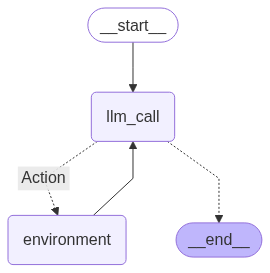

In [117]:
from langgraph.graph import StateGraph, START
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langgraph.graph import MessagesState
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore

agent_builder = StateGraph(MessagesState)
checkpointer = InMemorySaver()
store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1536,
        "fields": ["user_query", "reformulated_query", "final_response"]
    }
)

agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

agent_builder.add_edge(START, "llm_call")
agent_builder.add_edge("environment", "llm_call")

agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "Action": "environment",
        END: END,
    },
)

agent = agent_builder.compile(checkpointer=checkpointer, store=store)
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))


In [118]:
from langchain_core.messages import HumanMessage
from langchain_core.messages import AIMessage



messages = [HumanMessage(content=" What's the state with the most litigation claims?")]
config = {"configurable": { "user_id": '1', "thread_id": '2'}}
result = agent.invoke({"messages": messages},config=config)

for m in result["messages"]:
    m.pretty_print()




📄 Loading schema and metric definitions...
🛠️ SQL Worker received query: SELECT loss_location_state, COUNT(*) AS litigation_count FROM fnol_data WHERE litigation = 1 GROUP BY loss_location_state ORDER BY litigation_count DESC LIMIT 1;
💾 Saving memory...
✅ Memory saved.
================================ Human Message =================================

 What's the state with the most litigation claims?
================================== Ai Message ==================================
Tool Calls:
  get_schema_tool (call_8sCLSeCSZWJ38Sz0QPIbgCM8)
 Call ID: call_8sCLSeCSZWJ38Sz0QPIbgCM8
  Args:
================================= Tool Message =================================

=== TABLE SCHEMA ===
{
  "fnol_data": {
    "claim_number": "Unique identifier assigned to the insurance claim. Eg. C9CB6205",
    "policy_number": "Unique number linked to the insurance policy under which the claim is filed. Eg. PC171779360",
    "date_of_loss": "Date when the incident or loss occurred. Eg. 2025-04-01.",


In [119]:
from langchain_core.messages import HumanMessage

# for chunk in agent.stream(
#     {"messages": [{"role": "user", "content": "What's the state with the most litigation claims?"}]},
#     stream_mode="updates", config=config
# ):
#     print(chunk)
#     print("\n")


# for token, metadata in agent.stream(
#     {"messages": [{"role": "user", "content": "What's the state with the most litigation claims?"}]},
#     stream_mode="messages", config=config
# ):
#     print("Token", token)
#     print("Metadata", metadata)
#     print("\n")

messages = [HumanMessage(content=" What is litigation cost per claim there ?")]
config = {"configurable": { "user_id": '1', "thread_id": '2'}}
result = agent.invoke({"messages": messages},config=config)

# for m in result["messages"]:
#     m.pretty_print()

for m in result["messages"]:
    if isinstance(m, AIMessage):
        tool_calls = m.additional_kwargs.get("tool_calls", [])
        for call in tool_calls:
            tool_name = call["function"]["name"]
            args = call["function"]["arguments"]
            print(f"🛠️ Tool: {tool_name}\n📥 Args: {args}\n")


🛠️ SQL Worker received query: SELECT SUM(total_claim_bill) / COUNT(*) AS litigation_cost_per_claim FROM fnol_data WHERE litigation = 1 AND loss_location_state = 'Virginia';
💾 Saving memory...
✅ Memory saved.
🛠️ Tool: get_schema_tool
📥 Args: {}

🛠️ Tool: sql_worker_tool
📥 Args: {"query":"SELECT loss_location_state, COUNT(*) AS litigation_count FROM fnol_data WHERE litigation = 1 GROUP BY loss_location_state ORDER BY litigation_count DESC LIMIT 1;"}

🛠️ Tool: save_memory_tool
📥 Args: {"user_query":"What's the state with the most litigation claims?","final_response":"The state with the most litigation claims is Virginia, with a total of 4 claims involving litigation."}

🛠️ Tool: sql_worker_tool
📥 Args: {"query":"SELECT SUM(total_claim_bill) / COUNT(*) AS litigation_cost_per_claim FROM fnol_data WHERE litigation = 1 AND loss_location_state = 'Virginia';"}

🛠️ Tool: save_memory_tool
📥 Args: {"user_query":"What is litigation cost per claim in Virginia?","final_response":"The litigation cost 

In [120]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content=" What is litigation cost per claim there ?")]
config = {"configurable": { "user_id": '1', "thread_id": '2'}}
result = agent.invoke({"messages": messages},config=config)

for m in result["messages"]:
    m.pretty_print()


📚 Retrieving recent memory for user_id: 1
🧠 Retrieved 2 past memories
================================ Human Message =================================

 What's the state with the most litigation claims?
================================== Ai Message ==================================
Tool Calls:
  get_schema_tool (call_8sCLSeCSZWJ38Sz0QPIbgCM8)
 Call ID: call_8sCLSeCSZWJ38Sz0QPIbgCM8
  Args:
================================= Tool Message =================================

=== TABLE SCHEMA ===
{
  "fnol_data": {
    "claim_number": "Unique identifier assigned to the insurance claim. Eg. C9CB6205",
    "policy_number": "Unique number linked to the insurance policy under which the claim is filed. Eg. PC171779360",
    "date_of_loss": "Date when the incident or loss occurred. Eg. 2025-04-01.",
    "time_of_loss": "Time when the incident or loss took place. Eg. 04:03:07.",
    "loss_location": "Address or location where the loss or damage happened. Eg. 37802 Andre Shoals Suite 964 South Aman

In [121]:
# for m in result["messages"]:
#     if hasattr(m, "content") and m.type == "ai":
#         print(m.content)

In [122]:
messages = [HumanMessage(content=" Counsel shall not prepare detailed page and line digests")]
config = {"configurable": { "user_id": '1', "thread_id": '2'}}
result = agent.invoke({"messages": messages},config=config)

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

 What's the state with the most litigation claims?
================================== Ai Message ==================================
Tool Calls:
  get_schema_tool (call_8sCLSeCSZWJ38Sz0QPIbgCM8)
 Call ID: call_8sCLSeCSZWJ38Sz0QPIbgCM8
  Args:
================================= Tool Message =================================

=== TABLE SCHEMA ===
{
  "fnol_data": {
    "claim_number": "Unique identifier assigned to the insurance claim. Eg. C9CB6205",
    "policy_number": "Unique number linked to the insurance policy under which the claim is filed. Eg. PC171779360",
    "date_of_loss": "Date when the incident or loss occurred. Eg. 2025-04-01.",
    "time_of_loss": "Time when the incident or loss took place. Eg. 04:03:07.",
    "loss_location": "Address or location where the loss or damage happened. Eg. 37802 Andre Shoals Suite 964 South Amanda, KY 89536",
    "loss_location_state": "State of location where the

In [95]:
messages = [HumanMessage(content=" What is the Soft threshold damage amount for vehicles? check how many claims with total loss had total bill exceeding this threshold amount  ")]
config = {"configurable": { "user_id": '1', "thread_id": '2'}}
result = agent.invoke({"messages": messages},config=config)

for m in result["messages"]:
    m.pretty_print()

📥 RAG Worker received query: What is the soft threshold damage amount for vehicles?
🛠️ SQL Worker received query: SELECT COUNT(*) AS total_loss_claims_exceeding_threshold FROM fnol_data WHERE damage_description = 'Total loss' AND total_claim_bill > 3500;
💾 Saving memory...
✅ Memory saved.
================================ Human Message =================================

 What's the state with the most litigation claims?
================================== Ai Message ==================================
Tool Calls:
  get_schema_tool (call_JaIY642ffrtUqzm4KDkftFko)
 Call ID: call_JaIY642ffrtUqzm4KDkftFko
  Args:
================================= Tool Message =================================

=== TABLE SCHEMA ===
{
  "fnol_data": {
    "claim_number": "Unique identifier assigned to the insurance claim. Eg. C9CB6205",
    "policy_number": "Unique number linked to the insurance policy under which the claim is filed. Eg. PC171779360",
    "date_of_loss": "Date when the incident or loss occurred

In [134]:
messages = [HumanMessage(content="what is the threshold value for Total loss and What is the Soft threshold damage amount for vehicles?")]
config = {"configurable": { "user_id": '1', "thread_id": '2'}}
result = agent.invoke({"messages": messages},config=config)

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

 What's the state with the most litigation claims?
================================== Ai Message ==================================
Tool Calls:
  get_schema_tool (call_SScgue6TJqNb7aEhpAh9KdS6)
 Call ID: call_SScgue6TJqNb7aEhpAh9KdS6
  Args:
================================= Tool Message =================================

=== TABLE SCHEMA ===
{
  "fnol_data": {
    "claim_number": "Unique identifier assigned to the insurance claim. Eg. C9CB6205",
    "policy_number": "Unique number linked to the insurance policy under which the claim is filed. Eg. PC171779360",
    "date_of_loss": "Date when the incident or loss occurred. Eg. 2025-04-01.",
    "time_of_loss": "Time when the incident or loss took place. Eg. 04:03:07.",
    "loss_location": "Address or location where the loss or damage happened. Eg. 37802 Andre Shoals Suite 964 South Amanda, KY 89536",
    "loss_location_state": "State of location where the

In [135]:
messages = [HumanMessage(content="what is the threshold value for Total loss and What is the Soft threshold damage amount for vehicles?")]
config = {"configurable": { "user_id": '1', "thread_id": '2'}}
result = agent.invoke({"messages": messages},config=config)

for m in result["messages"]:
    m.pretty_print()

📥 RAG Worker received query: threshold value for Total loss and Soft threshold damage amount for vehicles
================================ Human Message =================================

 What's the state with the most litigation claims?
================================== Ai Message ==================================
Tool Calls:
  get_schema_tool (call_SScgue6TJqNb7aEhpAh9KdS6)
 Call ID: call_SScgue6TJqNb7aEhpAh9KdS6
  Args:
================================= Tool Message =================================

=== TABLE SCHEMA ===
{
  "fnol_data": {
    "claim_number": "Unique identifier assigned to the insurance claim. Eg. C9CB6205",
    "policy_number": "Unique number linked to the insurance policy under which the claim is filed. Eg. PC171779360",
    "date_of_loss": "Date when the incident or loss occurred. Eg. 2025-04-01.",
    "time_of_loss": "Time when the incident or loss took place. Eg. 04:03:07.",
    "loss_location": "Address or location where the loss or damage happened. Eg. 378

In [136]:
messages = [HumanMessage(content="expand on threshold value for Total loss")]
config = {"configurable": { "user_id": '1', "thread_id": '2'}}
result = agent.invoke({"messages": messages},config=config)

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

 What's the state with the most litigation claims?
================================== Ai Message ==================================
Tool Calls:
  get_schema_tool (call_SScgue6TJqNb7aEhpAh9KdS6)
 Call ID: call_SScgue6TJqNb7aEhpAh9KdS6
  Args:
================================= Tool Message =================================

=== TABLE SCHEMA ===
{
  "fnol_data": {
    "claim_number": "Unique identifier assigned to the insurance claim. Eg. C9CB6205",
    "policy_number": "Unique number linked to the insurance policy under which the claim is filed. Eg. PC171779360",
    "date_of_loss": "Date when the incident or loss occurred. Eg. 2025-04-01.",
    "time_of_loss": "Time when the incident or loss took place. Eg. 04:03:07.",
    "loss_location": "Address or location where the loss or damage happened. Eg. 37802 Andre Shoals Suite 964 South Amanda, KY 89536",
    "loss_location_state": "State of location where the

In [79]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content=" retreive most recent memory")]
config = {"configurable": { "user_id": '1', "thread_id": '2'}}
result = agent.invoke({"messages": messages},config=config)

for m in result["messages"]:
    m.pretty_print()

📚 Retrieving recent memory for user_id: 1
🧠 Retrieved 2 past memories
================================ Human Message =================================

 What's the state with the most litigation claims?
================================== Ai Message ==================================
Tool Calls:
  get_schema_tool (call_63PkVmJ9RiFHlS9U3thLNkR9)
 Call ID: call_63PkVmJ9RiFHlS9U3thLNkR9
  Args:
================================= Tool Message =================================

=== TABLE SCHEMA ===
{
  "fnol_data": {
    "claim_number": "Unique identifier assigned to the insurance claim. Eg. C9CB6205",
    "policy_number": "Unique number linked to the insurance policy under which the claim is filed. Eg. PC171779360",
    "date_of_loss": "Date when the incident or loss occurred. Eg. 2025-04-01.",
    "time_of_loss": "Time when the incident or loss took place. Eg. 04:03:07.",
    "loss_location": "Address or location where the loss or damage happened. Eg. 37802 Andre Shoals Suite 964 South Aman

In [123]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content=" suggest follow up questions")]
config = {"configurable": { "user_id": '1', "thread_id": '2'}}
result = agent.invoke({"messages": messages},config=config)

for m in result["messages"]:
    m.pretty_print()

🔎 Generating follow-up questions...
💡 Suggested follow-ups:
 ['What is the average settlement amount for litigation claims in Virginia?', "How does Virginia's litigation cost per claim compare to other states?", 'What types of claims are most commonly litigated in Virginia?', 'What is the total litigation cost for all claims in Virginia?', 'Are there any trends in litigation claims in Virginia over the past year?']


BadRequestError: Error code: 400 - {'error': {'message': "Invalid type for 'messages[25].content[0]': expected an object, but got a string instead.", 'type': 'invalid_request_error', 'param': 'messages[25].content[0]', 'code': 'invalid_type'}}